Welcome to a new series on interpretability where I'll go through methods to interpret models, starting from the linear regression to so called black-box ensembles. I wanted to start this series for a while, due to two reasons:

1. I feel like anything I write is helpful for me, like I'm explaining to my future self. So, anytime I can't recall something my own blog becomes my go-to source.
2. There seems to be a lot of confusions within the ML field in terms of interpretability (at least among the new comers), where most of the time wording suggest causality when it shouldn't. I think I learned a few approaches to be helpful for that as well.

If you want a book to find everything in one place your go-to source should be [*Interpretable ML*](https://christophm.github.io/interpretable-ml-book/) by Christoph Molnar. Most of the approaches that I learned is from there. I should also give credit to [*Regression and Other Stories*](https://avehtari.github.io/ROS-Examples/).

By the way, throughout the series I won't dive much into how to fit models. So, I assume some familiarity with GLMs, decision tree, and bagging and boosting methods in general. For example, I won't walk through the summary table below, assuming you already know how to read it.

Let's start with a *simple linear regression* where we only have predictor show a simple trick that aids the interpretability.

In [3]:
model = smf.ols('kid_score ~ mom_iq', data=cognitive)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     108.6
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           7.66e-23
Time:                        15:08:03   Log-Likelihood:                -1875.6
No. Observations:                 434   AIC:                             3755.
Df Residuals:                     432   BIC:                             3763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.7998      5.917      4.360      0.0

What the table above tells us is that: $\displaystyle \text{E[kid's score | mom's iq]} = 25.7998 + 0.61 \cdot \text{mom's iq}$

Which implies the intercept, 25.7998, is the expected value of kid's score when the mom's iq is 0. That doesn't make sense, right? Nobody has an IQ score of 0.

So, a way to make it make sense is via centering the predictor so that the intercept corresponds to the mean. Let me show.

In [4]:
offset = np.mean(cognitive['mom_iq'])
cognitive['mom_iq_c'] = cognitive['mom_iq'] - offset

model = smf.ols('kid_score ~ mom_iq_c', data=cognitive)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     108.6
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           7.66e-23
Time:                        15:08:03   Log-Likelihood:                -1875.6
No. Observations:                 434   AIC:                             3755.
Df Residuals:                     432   BIC:                             3763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     86.7972      0.877     98.993      0.0

As you can see, intercept has changed since now it corresponds to the expected value of kid's score when the *mom_iq* is the average.

In [5]:
print(np.round(cognitive['kid_score'].mean(), 4))

86.7972


What about the slope? Isn't it interpreted as *one unit increase in mom's IQ is associated with 0.61 increase of kid's score*?

I suggest you to stay away from such interpretation. The model does _not_ provide information about changes *within* units but about *comparisons between units*. So, the most secure way of interpretation is as follows:
*Under the model, a kid with a mom's score of x+1 will be, on average, 0.61 IQ higher compared to a kid with a mom's score of x.*

Let's extend this to a more general setting where there's more than 1 variable.

In [6]:
model = smf.ols('kid_score ~ mom_iq + mom_hs', data=cognitive)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     58.72
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           2.79e-23
Time:                        15:08:03   Log-Likelihood:                -1872.0
No. Observations:                 434   AIC:                             3750.
Df Residuals:                     431   BIC:                             3762.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        25.7315      5.875      4.380

In this setting, the coefficient corresponds to the *expected difference between two observations, or group of observations, that only differ on the interested predictor by 1.* Very simple way of showing it is like below:

$\displaystyle \beta_0 + \beta_1X_1 + \beta_2X_2$

$\displaystyle \beta_0 + \beta_1(X_1+1) + \beta_2X_2 = \beta_0 + \beta_1X_1 + \beta_1 + \beta_2X_2$

if I take the difference: $\displaystyle (\beta_0 + \beta_1X_1 + \beta_1 + \beta_2X_2) - (\beta_0 + \beta_1X_1 + \beta_2X_2) = \beta_1$

This also points out the problem with collinearity. If $X_1$ and $X_2$ changes together, how am I gonna be left with $\beta_1$ alone since others won't cancel each other. Hence, we won't be able to attribute the change to a single variable.

With these interpretations from the table in mind, we can also make use of plots which are more intuitive.

In [7]:
mean_kid_by_mom = cognitive.groupby('mom_iq')['kid_score'].mean()

In [8]:
low_end, high_end = cognitive['mom_iq'].min(), cognitive['mom_iq'].max()
qs = np.linspace(low_end, high_end, 101)

In [9]:
newdata_yes = pd.DataFrame()

newdata_yes['mom_iq'] = qs
newdata_yes['mom_hs'] = 'yes'
newdata_yes['preds'] = results.predict(newdata_yes)

In [10]:
newdata_no = pd.DataFrame()

newdata_no['mom_iq'] = qs
newdata_no['mom_hs'] = 'no'
newdata_no['preds'] = results.predict(newdata_no)

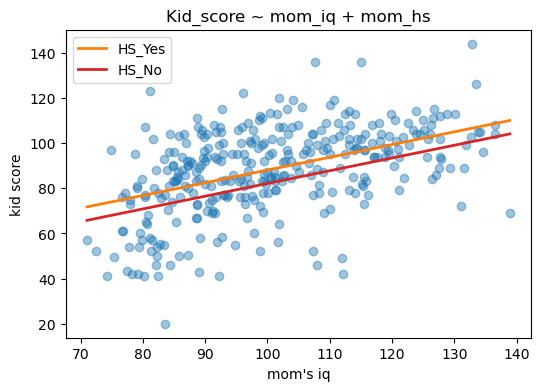

In [11]:
plt.figure(figsize=(6,4))

plt.plot(mean_kid_by_mom, 'o', alpha=.43)
plt.plot(newdata_yes['mom_iq'], newdata_yes['preds'], label='HS_Yes', color='C1', lw=2)
plt.plot(newdata_no['mom_iq'], newdata_no['preds'], label='HS_No', color='C3', lw=2)

plt.xlabel('mom\'s iq')
plt.ylabel('kid score')
plt.title('Kid_score ~ mom_iq + mom_hs')

plt.legend()

With plots, it's very easy to understand the model and its assumptions. By looking at the plot, for example, it's apparent that coefficient of *mom's iq* does not depend on high school variable — the slope is the same for both levels of high school.

We can include an interaction term in the model specification, so that it can depend on the level of high school.

In [12]:
model = smf.ols('kid_score ~ mom_iq + mom_hs + mom_iq:mom_hs', data=cognitive)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     42.84
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           3.07e-24
Time:                        15:08:04   Log-Likelihood:                -1867.5
No. Observations:                 434   AIC:                             3743.
Df Residuals:                     430   BIC:                             3759.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -11.4820 

Just like that, we allowed the coefficient of mom_iq to change depending on the level of mom_hs. But how do we interpret them now?

The most intuitive way is via the plot:

In [13]:
newdata_hs = pd.DataFrame()

newdata_hs['mom_iq'] = np.linspace(np.min(cognitive['mom_iq']), np.max(cognitive['mom_iq']), 101)
newdata_hs['mom_hs'] = 'yes'

pred_hs = results.predict(newdata_hs)

In [14]:
newdata_nohs = pd.DataFrame()

newdata_nohs['mom_iq'] = np.linspace(np.min(cognitive['mom_iq']), np.max(cognitive['mom_iq']), 101)
newdata_nohs['mom_hs'] = 'no'

pred_nohs = results.predict(newdata_nohs)

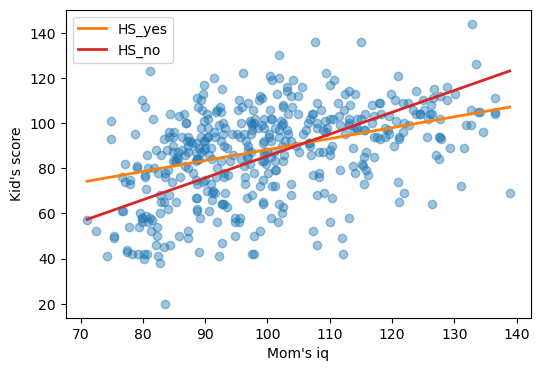

In [15]:
plt.figure(figsize=(6, 4))

plt.plot(cognitive['mom_iq'], cognitive['kid_score'], 'o', alpha=.43)
plt.plot(newdata_hs['mom_iq'], pred_hs, label='HS_yes', color='C1', ls='-', lw=2)
plt.plot(newdata_nohs['mom_iq'], pred_nohs, label='HS_no', color='C3', ls='-', lw=2)

plt.xlabel('Mom\'s iq')
plt.ylabel('Kid\'s score')
plt.legend()

Seaborn makes quick plotting available.

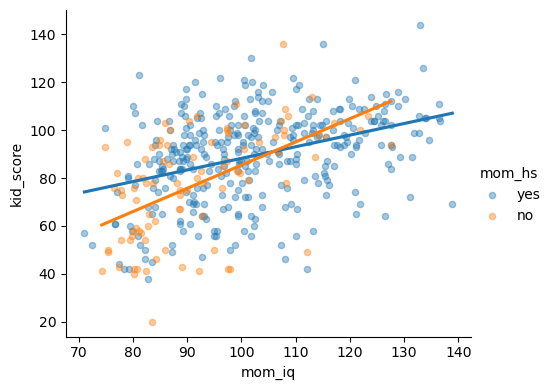

In [16]:
sns.lmplot(
    data=cognitive, x='mom_iq', y='kid_score', hue='mom_hs', 
    ci=None, scatter_kws={'alpha':.4, 's':20},
    height=4, aspect=1.23
)

Plots show that the lines are not parallel, so coefficients are not the same for both levels of high school variable.

I want to emphasize this, interaction effect is ADDITIVE to the main effect. Since interpretation of "while holding all other variables constant" is meaningless - we can't hold mom_iq constant while increasing the interaction variable.

What it means to be additive? Well, think of it this way. The coefficient of interaction is negative. When the high school level is yes, we add -0.4843 to the slope of the *mom_iq*. Since the coefficient of *mom_iq* positive, it means that mom_iq matters less when the level of high school is "yes".

I hope this post clarified some aspects of interpretation of linear models. Of course, there are extensions of the classic linear regression, called Generalized Linear Models (GLMs). Actually, linear regression itself is a special case in GLM framework where the link function is identity function.

Anyway, I believe I'll follow this up with model agnostic methods since most of you go for ML models. However, make no mistake, you may actually need these parametric approaches since you don't always end up with a lot of data.

Until then, take care!